## ПОИСК АНОМАЛИЙ (СИСТЕМА АЛЕРТОВ)

Система должна с периодичность каждые 15 минут проверять ключевые метрики, такие как:
- активные пользователи в ленте / мессенджере, 
- просмотры, 
- лайки, 
- CTR, 
- количество отправленных сообщений.    

Изучите поведение метрик и подберите наиболее подходящий метод для детектирования аномалий. На практике как правило применяются статистические методы. 
В самом простом случае можно, например, проверять отклонение значения метрики в текущую 15-минутку от значения в такую же 15-минутку день назад.     

В случае обнаружения аномального значения, в чат должен отправиться алерт - сообщение со следующей информацией: метрика, ее значение, величина отклонения.
В сообщение можно добавить дополнительную информацию, которая поможет при исследовании причин возникновения аномалии, это может быть, например,  график, ссылки на дашборд/чарт в BI системе.    

Пример шаблона алерта:     

```
Метрика {metric_name} в срезе {group}.     
Текущее значение {current_x}. Отклонение более {x}%.    
[опционально: ссылка на риалтайм чарт этой метрики в BI для более гибкого просмотра]    
[опционально: ссылка на риалтайм дашборд в BI для исследования ситуации в целом]    
@[опционально: тегаем ответственного/наиболее заинтересованного человека в случае отклонения конкретно 
  этой метрики в этом срезе (если такой человек есть)]     
   
[график] 
```

Основные составляющие скрипта кастомной системы алертинга: 

- перечень метрик и срезов для мониторинга 
- коннектор к БД для сбора данных
- алгоритм детектирования аномалии 
- функция для отправки алерта

Перед началом написания скрипта системы алертов необходимо:

- [x] определить перечень метрик и срезов 
- [x] изучить поведение метрик
- [x] продумать метод детектирования аномалий и частоту мониторинга значений метрик

### Метрики

- активные пользователи в ленте / мессенджере
- активные пользователи в мессенджере
- просмотры
- лайки
- CTR
- количество отправленных сообщений

### Срезы

- all
- OS
- source
- country (Russia и остальные)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from read_db import Getch

In [2]:
from tqdm import tqdm

In [3]:
sns.set()

#### Исследуем на примере активных юзеров в ленте

In [4]:
feed_users_query = """
with toDateTime('2022-04-28 15:03:00') as _now --зафиксируем время для воспроизводимости результатов
SELECT
  toStartOfFifteenMinutes(time) time_15,
  formatDateTime(time_15, '%R') as hour_min,
  count(distinct user_id) "active_users"
FROM simulator_20220420.feed_actions
where toStartOfFifteenMinutes(time) <> toStartOfFifteenMinutes(_now)
  and dateDiff('minute', time, _now) <= 2 * 7 * 24 * 60 + 15
  and time < _now
group by toStartOfFifteenMinutes(time), formatDateTime(time_15, '%R')
order by time_15
"""

In [5]:
feed_users_data = Getch(feed_users_query).df

In [6]:
feed_users_data.head()

time_15 hour_min  active_users
0 2022-04-14 14:45:00    14:45           510
1 2022-04-14 15:00:00    15:00           488
2 2022-04-14 15:15:00    15:15           520
3 2022-04-14 15:30:00    15:30           518
4 2022-04-14 15:45:00    15:45           527

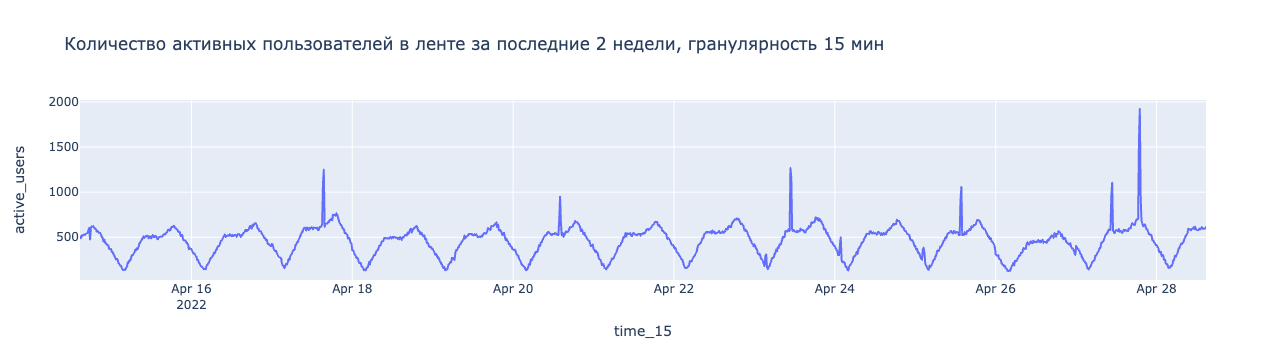

In [7]:
fig = px.line(
    feed_users_data, 
    x="time_15", 
    y="active_users", 
    title="Количество активных пользователей в ленте за последние 2 недели, гранулярность 15 мин", 
)
fig.show()

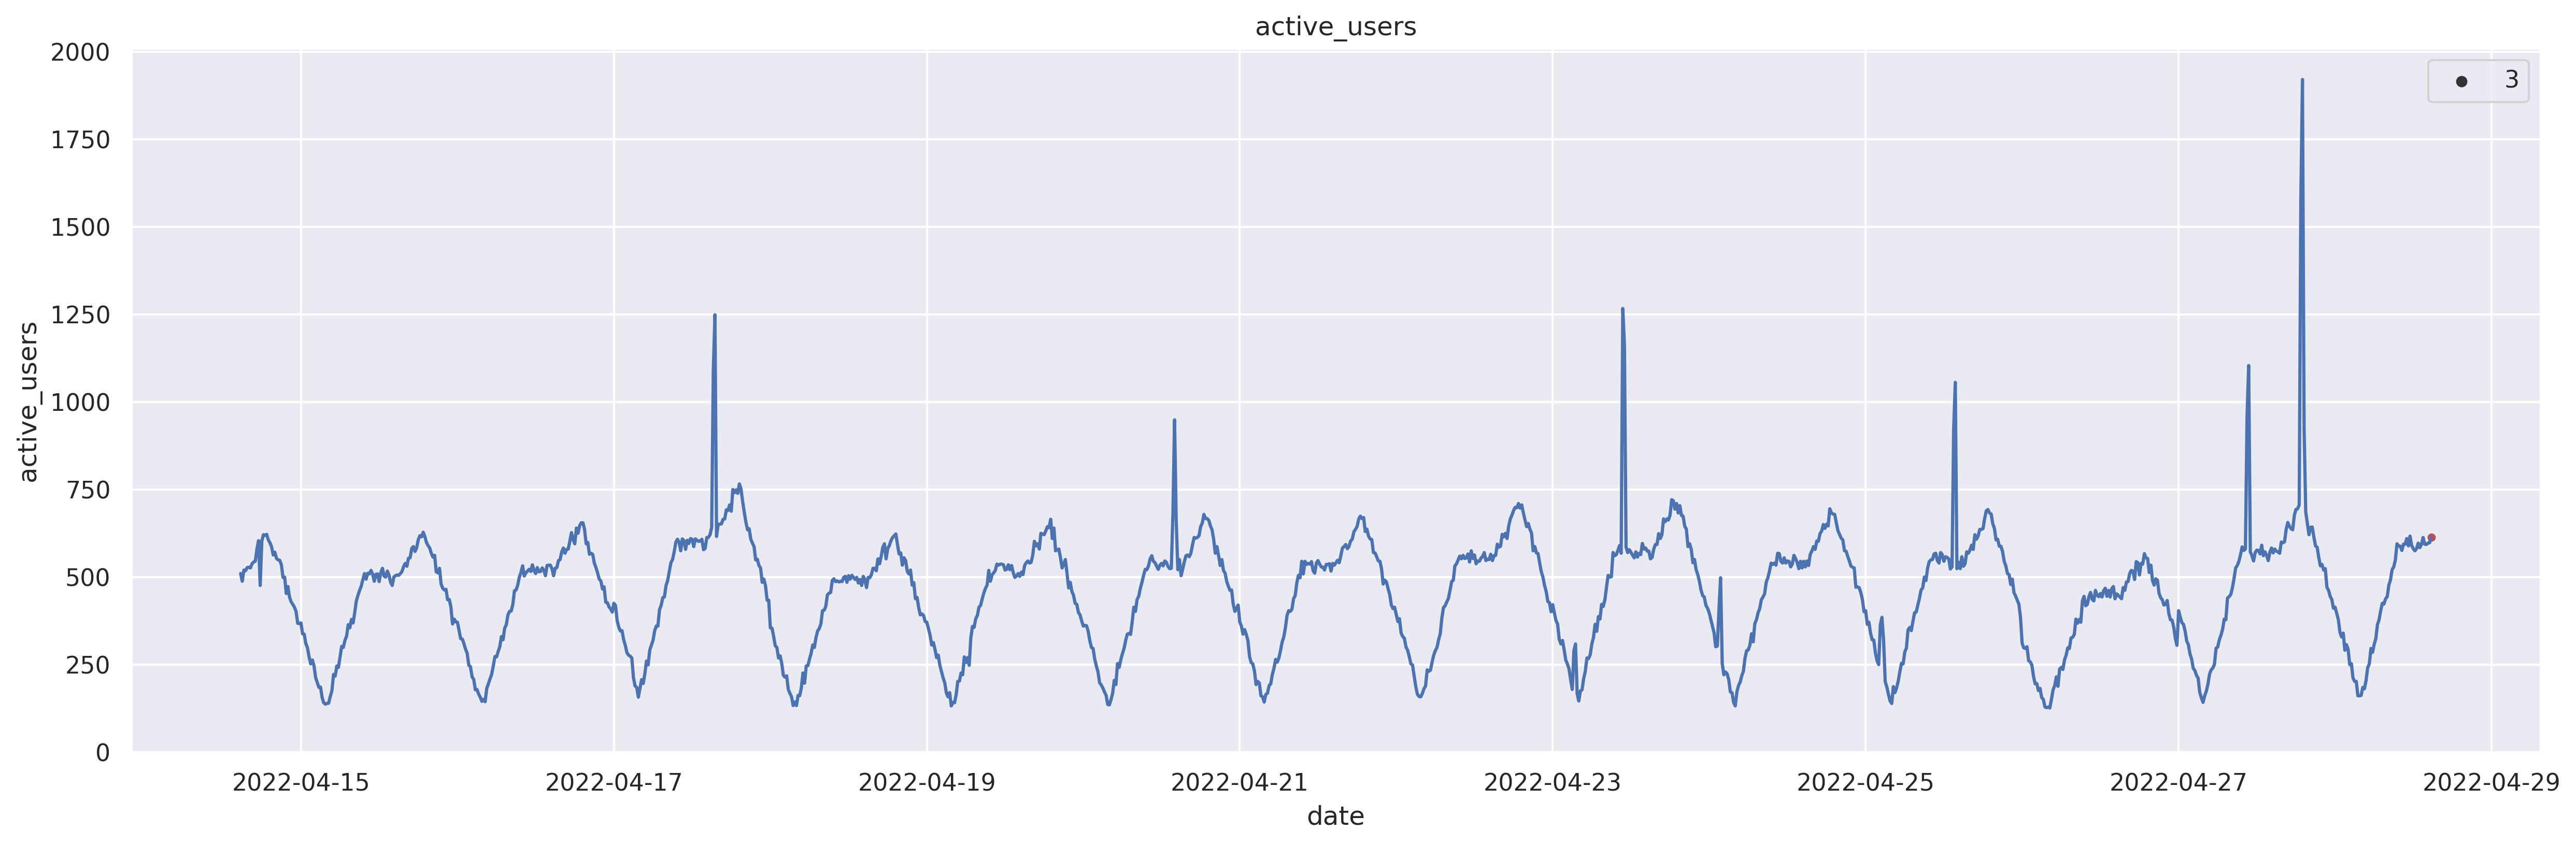

In [21]:
sns.set(rc={'figure.figsize': (20, 6), 'figure.dpi': 300}) 

ax = sns.lineplot(
    data=feed_users_data, 
    x="time_15", 
    y='active_users', 
    )

sns.scatterplot(
    data=feed_users_data.tail(1), 
    x="time_15", 
    y='active_users',
    color='r',
    )

ax.set(xlabel='date')
ax.set(ylabel='active_users')

ax.set_title('active_users')
ax.set(ylim=(0, None))

plt.show()

#### Посмотрим на колебание текущей 15-ти минутки за прошедшие 2 недели

In [8]:
current_hour_min = feed_users_data['hour_min'].iloc[-1]

In [9]:
curr_15_min_history = feed_users_data[feed_users_data['hour_min'] == current_hour_min]

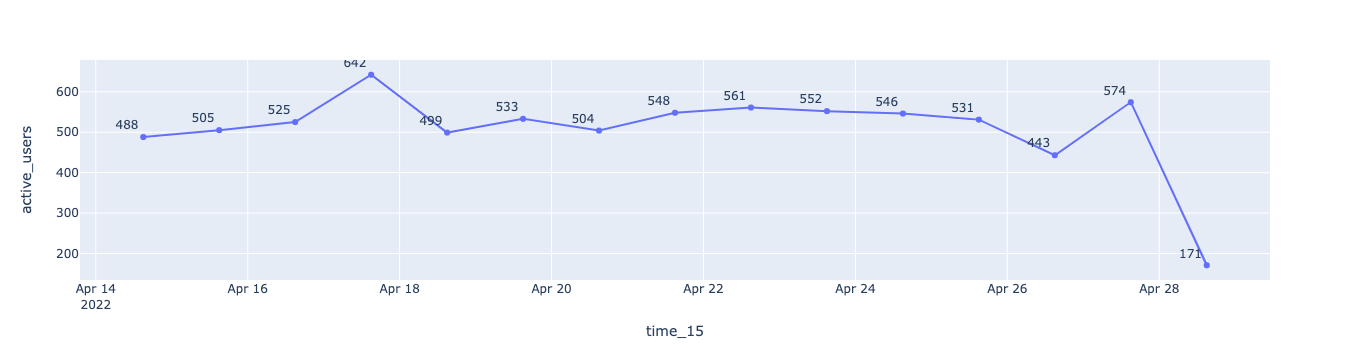

In [10]:
fig = px.line(
    curr_15_min_history, 
    x="time_15", 
    y="active_users",  
    text="active_users",
)
fig.update_traces(textposition="top left")
fig.show()

### Попробуем межквартильный размах

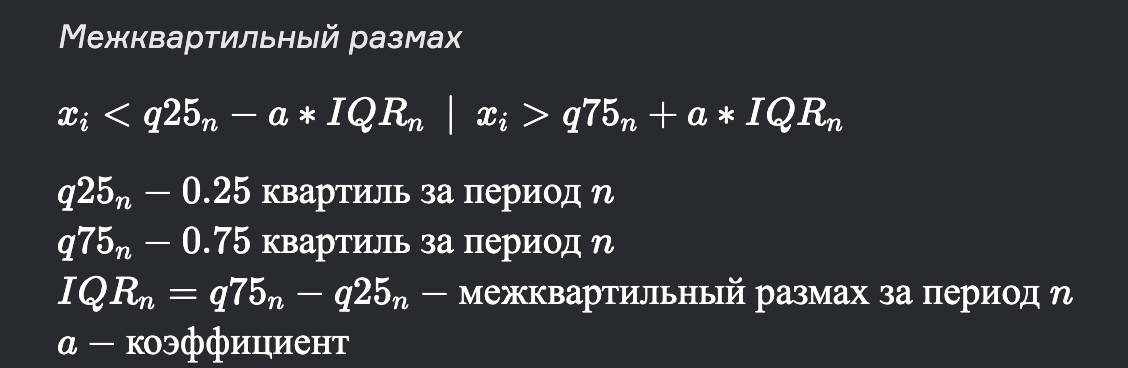

In [11]:
curr_15_min_history['active_users'].iloc[:-1].describe()

count     14.000000
mean     532.214286
std       46.464508
min      443.000000
25%      504.250000
50%      532.000000
75%      551.000000
max      642.000000
Name: active_users, dtype: float64

x_i = 613    
igr = 556 - 506 = 50     
a = 1.5 (стандартный коэффициент для определения аномалий в данных)    
q25 - 1.5 * iqr = 506 - 1.5 * 50 = 431    
q75 + 1.5 * iqr = 556 + 1.5 * 50 = 631     
      
x_i попадает в интервал    

In [12]:
stat = curr_15_min_history['active_users'].iloc[:-1].describe()

In [21]:
x_i = curr_15_min_history['active_users'].iloc[-1]
x_i

171

In [14]:
iqr = stat['75%'] - stat['25%']

In [15]:
a = 1.5

In [16]:
low_boundary = stat['25%'] - a * iqr

In [17]:
low_boundary

434.125

In [18]:
high_boundary = stat['75%'] + a * iqr

In [19]:
high_boundary

621.125

In [20]:
if x_i < low_boundary or x_i > high_boundary:
    print("Alarm!")

Alarm!


#### Соберем проверку в функцию

In [59]:
def check_alert(data: pd.DataFrame, time_col: str, metric_col: str, hour_min_col: str, a: float = 1.5) -> bool:
    if time_col not in data.columns:
        raise Exception(f"KeyError: '{time_col}' not in DataFrame")
    if metric_col not in data.columns:
        raise Exception(f"KeyError: '{metric_col}' not in DataFrame")
    if hour_min_col not in data.columns:
        raise Exception(f"KeyError: '{hour_min_col}' not in DataFrame")
        
    current_hour_min = data[hour_min_col].iloc[-1]
    curr_15_min_history = data[data[hour_min_col] == current_hour_min]
    
    # считаем статистику, не учитывая 15-минутуку, которую будем проверять на аномалию
    stat = curr_15_min_history[metric_col].iloc[:-1].describe()
    x_i = curr_15_min_history[metric_col].iloc[-1]
    iqr = stat['75%'] - stat['25%']
    
    low_boundary = stat['25%'] - a * iqr
    high_boundary = stat['75%'] + a * iqr
    
    # less than 4*Q1-3*Q3 or greater than 4*Q3-3*Q1
    # low_boundary = 4 * stat['25%'] - 3 * stat['75%']
    # high_boundary = 4 * stat['75%'] - 3 * stat['25%']
    
    
    if x_i < low_boundary or x_i > high_boundary:
        has_anomaly = True
    else:
        has_anomaly = False
        
    return has_anomaly, data[time_col].iloc[-1], x_i, current_hour_min 

In [23]:
check_alert(feed_users_data, 'time_15', 'active_users', 'hour_min')

(True, Timestamp('2022-04-28 15:00:00'), 171, '15:00')

#### Поищем аномалии в истории

In [34]:
curr_test_time = pd.date_range("2022-04-25 10:03:00'", "2022-04-28 15:03:00'", freq="15min")

In [25]:
anom_dts = []

for dt in tqdm(curr_test_time):
    # print(dt)
    _feed_users_query = f"""
    with toDateTime('{dt}') as _now --зафиксируем время для воспроизводимости результатов
    SELECT
      toStartOfFifteenMinutes(time) time_15,
      formatDateTime(time_15, '%R') as hour_min,
      count(distinct user_id) "active_users"
    FROM simulator_20220420.feed_actions
    where toStartOfFifteenMinutes(time) <> toStartOfFifteenMinutes(_now)
      and dateDiff('minute', time, _now) <= 2 * 7 * 24 * 60 + 15
      and time < _now
    group by toStartOfFifteenMinutes(time), formatDateTime(time_15, '%R')
    order by time_15
    """
    
    _feed_users_data = Getch(_feed_users_query).df
    
    is_anom, anom_dt, _, _ = check_alert(_feed_users_data, 'time_15', 'active_users', 'hour_min', a=3)
    
    if is_anom:
        anom_dts.append(anom_dt)

100%|██████████| 405/405 [06:49<00:00,  1.01s/it]


In [31]:
len(anom_dts)

10

In [32]:
anomaly_data = feed_users_data[feed_users_data['time_15'].isin(anom_dts)]

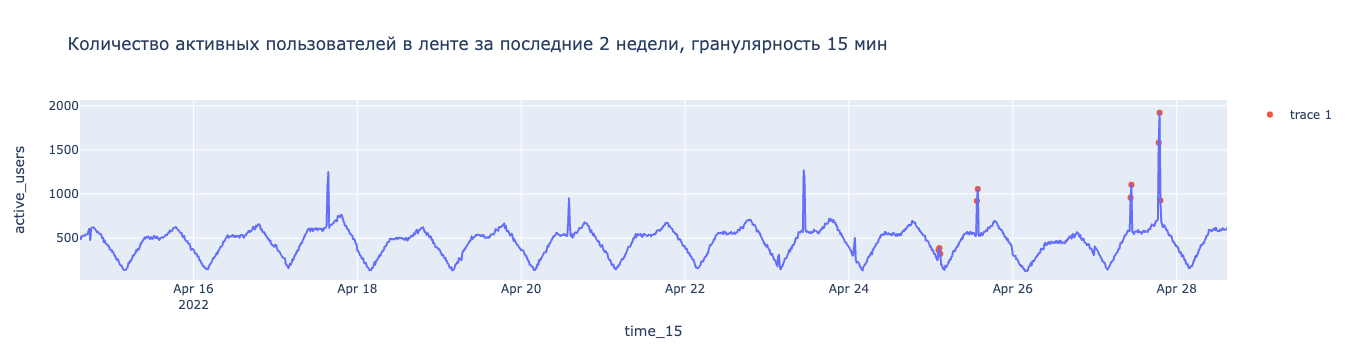

In [33]:
fig = px.line(
    feed_users_data, 
    x="time_15", 
    y="active_users", 
    title="Количество активных пользователей в ленте за последние 2 недели, гранулярность 15 мин", 
)
fig.add_scatter(x=anomaly_data['time_15'], y=anomaly_data['active_users'], mode='markers')

fig.show()

### Резюме для метрики "активные пользователи в ленте" в разрезе "all"
Запрос:
```sql
SELECT
  toStartOfFifteenMinutes(time) time_15,
  formatDateTime(time_15, '%R') as hour_min,
  count(distinct user_id) as active_users
FROM simulator_20220420.feed_actions
where toStartOfFifteenMinutes(time) <> toStartOfFifteenMinutes(now())
  and dateDiff('minute', time, now()) <= 2 * 7 * 24 * 60 + 15
group by toStartOfFifteenMinutes(time), formatDateTime(time_15, '%R')
order by time_15
```
Параметр `a` для поиска аномалий с помощью межквартильного размаха = 3

### Посмотрим в разрезе OS

In [52]:
curr_test_time = pd.date_range("2022-05-05 10:03:00'", "2022-05-05 16:50:00'", freq="15min")

In [60]:
anom_dts = []
_feed_users_data = None

for dt in tqdm(curr_test_time):
    # print(dt)
    _feed_users_query = f"""
    with toDateTime('{dt}') as _now --зафиксируем время для воспроизводимости результатов
    SELECT
      toStartOfInterval(time, INTERVAL 30 minute) time_30,
      formatDateTime(time_30, '%R') as hour_min,
      count(distinct user_id) "active_users"
    FROM simulator_20220420.message_actions
    where toStartOfInterval(time, INTERVAL 30 minute) <> toStartOfInterval(_now, INTERVAL 30 minute)
      and dateDiff('minute', time, _now) <= 2 * 7 * 24 * 60 + 30
      and time < _now
      --and os = 'Android'
    group by time_30, formatDateTime(time_30, '%R')
    order by time_30
    """
    
    _feed_users_data = Getch(_feed_users_query).df
    
    is_anom, anom_dt, _, _ = check_alert(_feed_users_data, 'time_30', 'active_users', 'hour_min', a=2.5)
    
    if is_anom:
        anom_dts.append(anom_dt)

100%|██████████| 28/28 [00:05<00:00,  5.33it/s]


In [61]:
len(anom_dts)

0

In [55]:
anomaly_data = _feed_users_data[_feed_users_data['time_15'].isin(anom_dts)]

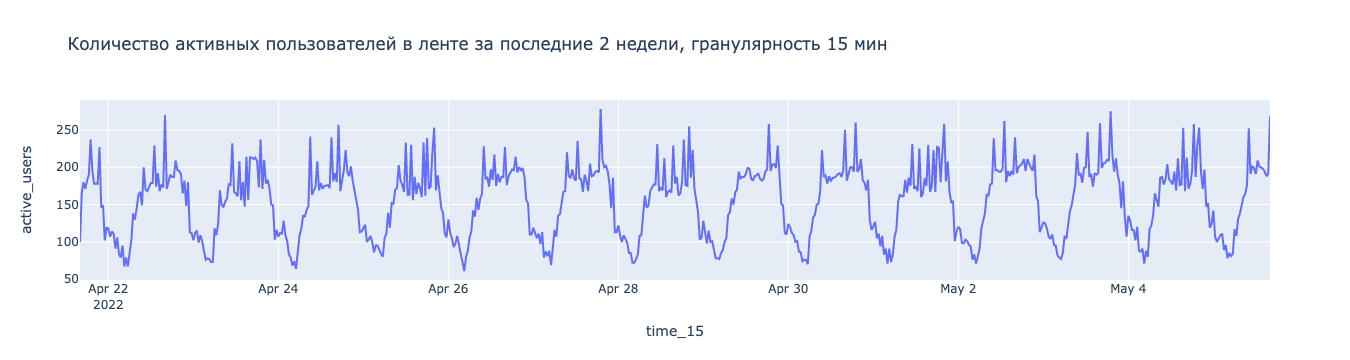

In [56]:
fig = px.line(
    _feed_users_data, 
    x="time_15", 
    y="active_users", 
    title="Количество активных пользователей в ленте за последние 2 недели, гранулярность 15 мин", 
)
fig.add_scatter(x=anomaly_data['time_15'], y=anomaly_data['active_users'], mode='markers')

fig.show()

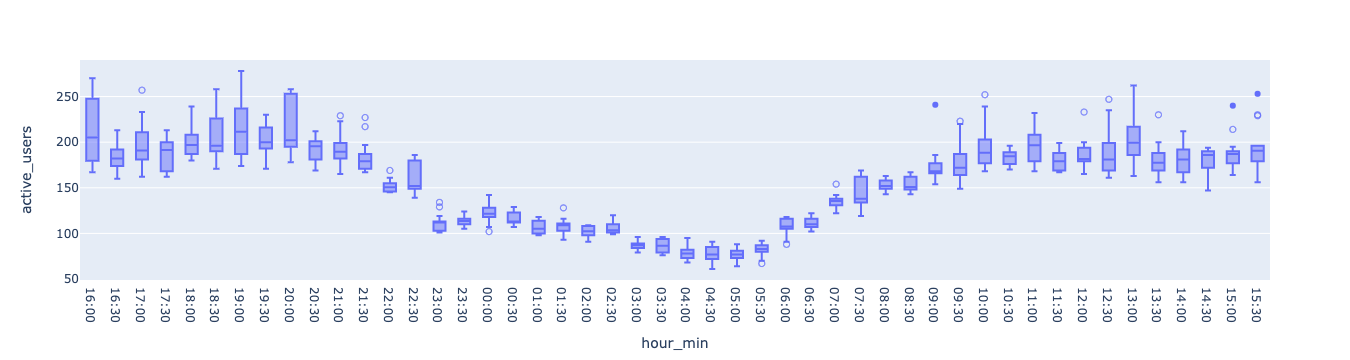

In [51]:
fig = px.box(_feed_users_data, x="hour_min", y="active_users", points='suspectedoutliers')
fig.show()

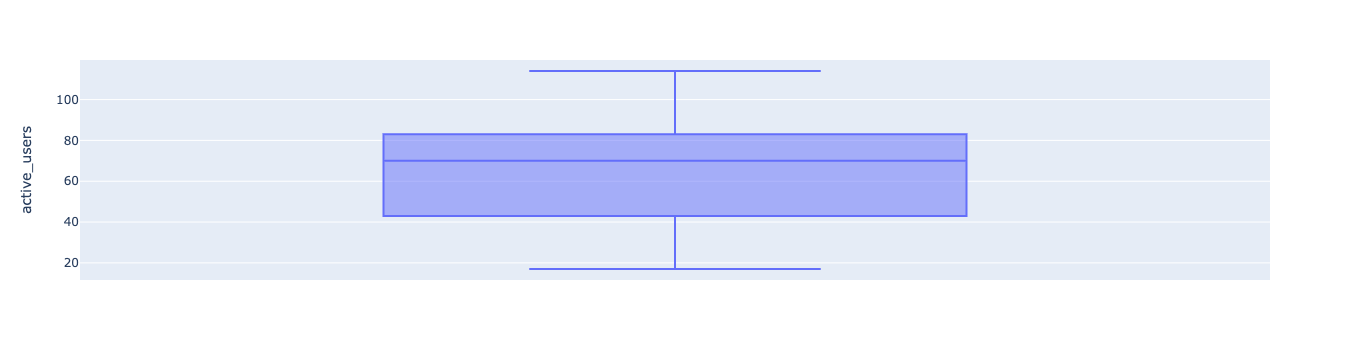

In [16]:
fig = px.box(_feed_users_data, y="active_users", points='suspectedoutliers')
fig.show()

### Напишем конфиг для метрик

### Метрики

- активные пользователи в ленте
- активные пользователи в мессенджере
- просмотры
- лайки
- CTR
- количество отправленных сообщений

### Срезы

- all
- OS
- source
- country (Russia и остальные)

### График для бота

In [75]:
_feed_users_data['date'] = _feed_users_data['time_15'].dt.date

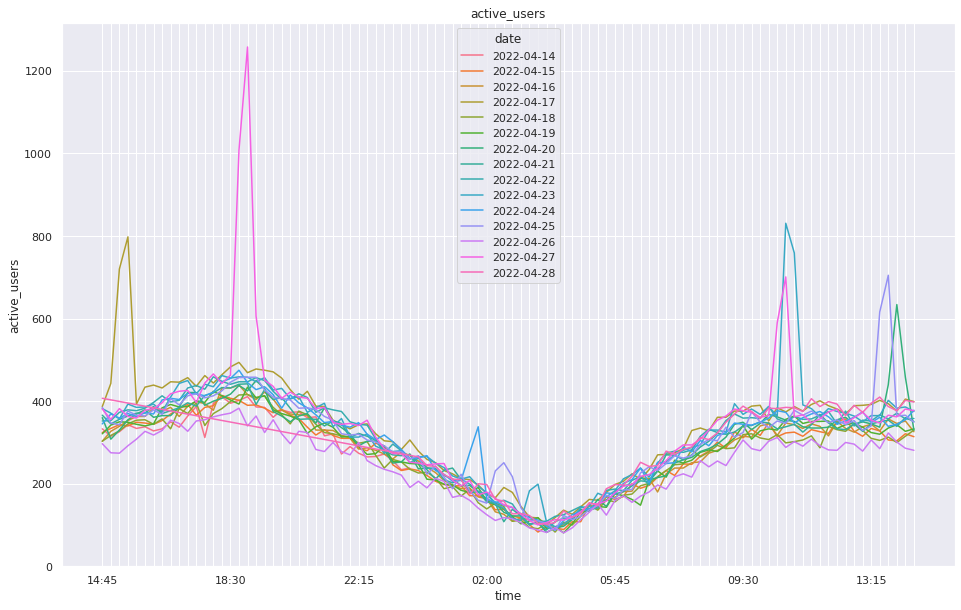

In [78]:
sns.set(rc={'figure.figsize': (16, 10)}) # задаем размер графика
plt.tight_layout()

ax = sns.lineplot( # строим линейный график
    data=_feed_users_data.sort_values(['time_15']), # задаем датафрейм для графика
    x="hour_min", y='active_users', # указываем названия колонок в датафрейме для x и y
    hue="date" # задаем "группировку" на графике, т е хотим чтобы для каждого значения date была своя линия построена
    )

for ind, label in enumerate(ax.get_xticklabels()): # этот цикл нужен чтобы разрядить подписи координат по оси Х,
    if ind % 15 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set(xlabel='time') # задаем имя оси Х
ax.set(ylabel='active_users') # задаем имя оси У

ax.set_title('{}'.format('active_users')) # задае заголовок графика
ax.set(ylim=(0, None)) # задаем лимит для оси У

plt.show()